In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlalchemy
import yfinance as yf
import datetime as dt

In [5]:
# Define ticker symbol and start/end dates
ticker = 'TSLA'
start = dt.datetime(2020, 1, 1)
end = dt.datetime.now()

# Download historical data
stock_data = yf.download(ticker, start=start, end=end)

stock_data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,28.299999,28.713333,28.114000,28.684000,28.684000,142981500
2020-01-03,29.366667,30.266666,29.128000,29.534000,29.534000,266677500
2020-01-06,29.364668,30.104000,29.333332,30.102667,30.102667,151995000
2020-01-07,30.760000,31.441999,30.224001,31.270666,31.270666,268231500
2020-01-08,31.580000,33.232666,31.215334,32.809334,32.809334,467164500


In [11]:
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1170 entries, 2020-01-02 to 2024-08-26
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1170 non-null   float64
 1   High       1170 non-null   float64
 2   Low        1170 non-null   float64
 3   Close      1170 non-null   float64
 4   Adj Close  1170 non-null   float64
 5   Volume     1170 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 64.0 KB


In [12]:
stock_data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1170.000000,1170.000000,1170.000000,1170.000000,1170.000000,1.170000e+03
mean,207.209676,211.868207,202.238224,207.150444,207.150444,1.283304e+08
std,80.511525,82.122325,78.607492,80.326545,80.326545,8.390149e+07
min,24.980000,26.990667,23.367332,24.081333,24.081333,2.940180e+07
25%,169.145000,174.332500,166.589996,170.089996,170.089996,7.707188e+07
50%,216.840004,221.771667,211.229996,216.570000,216.570000,1.039106e+08
75%,255.817505,260.682495,250.538334,256.519997,256.519997,1.485029e+08
max,411.470001,414.496674,405.666656,409.970001,409.970001,9.140820e+08


<Axes: title={'center': 'TSLA Adj Close Data'}, xlabel='Date'>

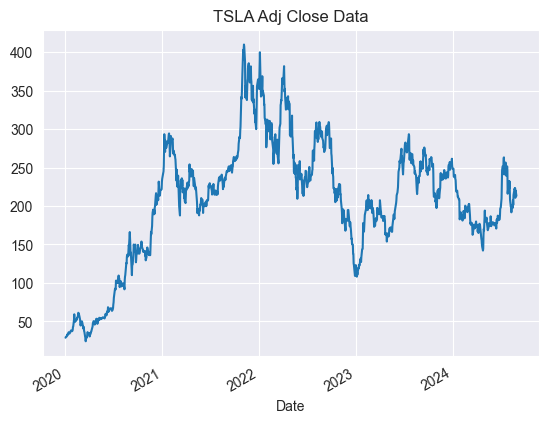

In [13]:
stock_data['Adj Close'].plot(title='TSLA Adj Close Data')

In [14]:
null = stock_data.isnull().sum()
print(null)

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [15]:
duplicates = stock_data.duplicated().sum()
print(duplicates)

0


In [16]:
stock_data.to_csv('stock_data.csv')